# Dimensionality Reduction on HR Analytics Data 

In this notebook I will compare both **feature selection** and **feature extraction** for dimensionality reduction.

Datset: [HR Analytics dataset](https://www.kaggle.com/ludobenistant/hr-analytics).
##### NOTE

The goal is the get the best performance from the **Naive Bayes** model using feature reduction techniques. 
We can expect that a different model may be more suitable; however, I want to only have a single moving part at a time so let's just stick with Naive Bayes.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import numpy as np
import pandas as pd
np.random.seed(18937)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.base import clone

## Let'sload the HR dataset

I'll load dataset into a DataFrame and shuffle.

In [2]:
# Dataset location
DATASET = '/dsa/data/all_datasets/HR_analytics.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Let's print top 5 rows of the dataset to take a peak at the variables. 

In [3]:
dataset.iloc[:6,:]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.85,0.90,5,202,3,0,0,0,IT,low
1,0.12,0.60,2,194,4,0,0,0,technical,medium
2,0.40,0.47,2,136,3,0,1,0,hr,medium
3,0.47,0.55,4,122,5,1,0,0,marketing,medium
4,0.89,0.65,5,195,6,0,1,0,support,low
5,0.80,0.83,4,183,2,1,0,1,support,low


In [4]:
dataset.columns # check column names

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

## Processing

In the dataset, "sales" and "salary" are string columns,
which need some proccessing before I can start feature selection/extraction.


In [5]:
from sklearn import preprocessing

# create an Binarize object from the scikit learn labelBinarizer function 
encoder = preprocessing.LabelBinarizer()

# this creates a numpy array of 1 and zeros on the salary column - for each categorical variable it codes a one or zero.
salary_features = encoder.fit_transform(np.expand_dims(dataset.salary, 1))

# this bit of code iterates over the encoder.classes_ object created above and 
# creates three new columns (one for every categorical variable).  Uses the categorical variable as a new column name 
# and stores the one or zero in each new column 
for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, 'salary_{}'.format(_class.replace('\x20', '_'))] = salary_features[:, j]

dataset.iloc[:12,:]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,salary_high,salary_low,salary_medium
0,0.85,0.90,5,202,3,0,0,0,IT,low,0,1,0
1,0.12,0.60,2,194,4,0,0,0,technical,medium,0,0,1
2,0.40,0.47,2,136,3,0,1,0,hr,medium,0,0,1
3,0.47,0.55,4,122,5,1,0,0,marketing,medium,0,0,1
4,0.89,0.65,5,195,6,0,1,0,support,low,0,1,0
5,0.80,0.83,4,183,2,1,0,1,support,low,0,1,0
6,0.61,0.50,4,216,2,0,0,0,technical,low,0,1,0
7,0.57,0.59,4,197,3,0,0,0,sales,low,0,1,0
8,0.58,0.53,4,192,4,0,0,0,IT,medium,0,0,1
9,0.62,0.68,3,226,3,0,0,0,technical,medium,0,0,1


Now please write similar code for "sales" column like what we just did above. Feel free to drop questions on disscussion board if you need clarification.

In [6]:
# let's first view the categorical variables in the sales column.  Looks like there's 10 different variables
dataset.sales.unique()

array(['IT', 'technical', 'hr', 'marketing', 'support', 'sales',
       'management', 'product_mng', 'RandD', 'accounting'], dtype=object)

In [7]:
# create an Binarize object from the scikit learn labelBinarizer function 
encoder = preprocessing.LabelBinarizer()

# this creates a numpy array of 1 and zeros on the sales column - for each 10 categorical variables it codes a one or zero.
sales_features = encoder.fit_transform(np.expand_dims(dataset.sales, 1))

# this bit of code iterates over the encoder.classes_ object created above and 
# creates three new columns (one for every categorical variable).  Uses the categorical variable as a new column name 
# and stores the one or zero in each new column 
for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, 'sales_{}'.format(_class.replace('\x20', '_'))] = sales_features[:, j]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 23 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
salary_high              14999 non-null int64
salary_low               14999 non-null int64
salary_medium            14999 non-null int64
sales_IT                 14999 non-null int64
sales_RandD              14999 non-null int64
sales_accounting         14999 non-null int64
sales_hr                 14999 non-null int64
sales_management         14999 non-null int64
sales_marketing          14999 non-null int64
sales_produ

I store feature columns (all columns except 'left', 'sales' and 'salary') to a new variable **X**.

Then I'll store the label column into a new variable **y**.

In [8]:
# make sure this code is selecting the columns desired 
newdata = dataset.iloc[:, np.r_[0:6, 7:8, 10:23]]

# view output before it goes into an array 
newdata.info()

# use iloc and np.r_ to select columns and store them into a new variable X - a numpy array 
X = np.array(dataset.iloc[:, np.r_[0:6, 7:8, 10:23]])

# Grab the target variable and store it into a numpy array named y
y = np.array(dataset.left)

# take a look at the data 
print(X[:4])
print(y) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 20 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
promotion_last_5years    14999 non-null int64
salary_high              14999 non-null int64
salary_low               14999 non-null int64
salary_medium            14999 non-null int64
sales_IT                 14999 non-null int64
sales_RandD              14999 non-null int64
sales_accounting         14999 non-null int64
sales_hr                 14999 non-null int64
sales_management         14999 non-null int64
sales_marketing          14999 non-null int64
sales_product_mng        14999 non-null int64
sales_sales              14999 non-null int64
sales_support            14999 non-null int64
sales_technic

I will now create train/validate split (20% validation ratio)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Feature selection and evaluation

Steps I'll take:
1. Initialize a feature selector
2. Fit feature selector on training set
3. Print indices of features selected, the "support".
4. Train a Gaussian Naive Bayes model on selected features from training set.
5. Evaluate the model by measuring its accuracy on the test set.


In [10]:
# Feature Selection with Chi Square 

# STEP 1: initialize a feature selector 
selector = SelectKBest(chi2, k=6)

# STEP 2: fit feature selector on training set 
selector.fit(X_train, y_train)
print(selector.scores_)

# STEP 3: print indicies of features selected - the support 
print(selector.get_support(True))

# STEP 3a: reduciing the features into another dataframe 
# x2reduced = dataset.iloc[:, [0, 3, 4, 5, 6, 7, 8, 9, 11, 14]]

# STEP 3b: printing a head w/column names of the reduced chi square dataframe 
#print(x2reduced.info())

# STEP 4: train a Gaussian Naive Bayes model on selected features from training set 
# STEP 4a: Call selector.transform() method to select those feature columns from dataset
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# STEP 4b: create Gaussian Naive Bayes model and fit it to the selected features 
model = GaussianNB()
model.fit(X_train_selected, y_train)

# STEP 5: evaluate the model by measuring its accuracy on the test set 
score = model.score(X_test_selected, y_test)

# print score 
print("Chi Square NB Model Score: ", score)

# import other libraries for assessing model 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# make predictions with model
predictions = model.predict(X_test_selected)

# compute and view confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test, predictions.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, predictions)
print("Chi Square NB Model Accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test, predictions, average='micro')
print("Chi Square NB Model Precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test, predictions.astype('i4'), average='micro')
print("Chi Square NB f1 score: ", f1)

[  1.81535117e+02   4.48445122e-02   3.72329462e+00   7.94896891e+02
   1.56525975e+02   2.51281160e+02   4.78547228e+01   1.61801609e+02
   1.21291796e+02   3.75952950e+01   6.37107974e-01   2.80140334e+01
   4.04950887e+00   1.07948130e+01   2.27176338e+01   6.14596997e-02
   2.89620782e+00   4.43749081e-02   1.58555395e+00   5.10618897e+00]
[0 3 4 5 7 8]
Chi Square NB Model Score:  0.776333333333
[[1801  497]
 [ 174  528]]
Chi Square NB Model Accuracy:  0.776333333333
Chi Square NB Model Precision:  0.776333333333
Chi Square NB f1 score:  0.776333333333


In [11]:
# looking at the Chi Square Statistic and the p-values 
chi2_sklearn, pvalue_sklearn = chi2(X, y)
print("Chi-Squared Statistic")
print(chi2_sklearn)

print("P-Values")
print(pvalue_sklearn)

Chi-Squared Statistic
[  2.28193183e+02   2.64642367e-02   3.39020494e+00   9.45588933e+02
   1.91708547e+02   3.06737710e+02   5.60448653e+01   2.01254596e+02
   1.39446529e+02   4.05239215e+01   1.64371371e+00   3.08564507e+01
   3.28865914e+00   1.13793626e+01   3.04516067e+01   1.04417630e-02
   1.71479003e+00   1.06932924e+00   1.46206955e+00   4.94905082e+00]
P-Values
[  1.47701843e-051   8.70771716e-001   6.55847967e-002   1.20671018e-207
   1.34710265e-043   1.12177164e-068   7.08359651e-014   1.11187274e-045
   3.51760165e-032   1.94223558e-010   1.99816694e-001   2.77837057e-008
   6.97599693e-002   7.42645951e-004   3.42299713e-008   9.18609877e-001
   1.90365066e-001   3.01097003e-001   2.26601121e-001   2.61049970e-002]


In [20]:
# Feature Selection with Mutual Info Session 

def mutual_info_session():
    selector = SelectKBest(mutual_info_classif, k=6)
    selector.fit(X_train, y_train)
    print(selector.get_support(True))
    model = GaussianNB()
    model.fit(selector.transform(X_train), y_train)
    return model.score(selector.transform(X_test), y_test)
    
mutal_info_score = mutual_info_session()

print("mutal info NB Model Score: ", mutal_info_score)

[0 1 2 3 4 8]
mutal info NB Model Score:  0.815


In [21]:
# Feature Selection with F-Regression 

selector = SelectKBest(f_regression, k=6)
selector.fit(X_train, y_train)
print('score', selector.scores_)
print('Selected indices', selector.get_support(True))

# reduciing the features into another dataframe 
#x2reduced = newdata.iloc[:, [0, 4, 5, 7, 8] # when selecting 5 features 
#x2reduced = dataset.iloc[:, [0, 3, 4, 5, 6, 7, 8, 9, 11, 14]]  # when selecting 10 features 

#x2reduced.info() # note these were the same columns selected in the chi square feature selection 

# train a Gaussian Naive Bayes model on selected features from training set 
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# create Gaussian Naive Bayes model and fit it to the selected features 
model = GaussianNB()
model.fit(X_train_selected, y_train)

# evaluate the model by measuring its accuracy on the test set 
score = model.score(X_test_selected, y_test)

print("F-Regression NB Model Score: ", score)

# make predictions with model
predictions = model.predict(X_test_selected)

# compute and view confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test, predictions.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, predictions)
print("F-Regression NB Model Accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test, predictions, average='micro')
print("F-Regression NB Model Precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test, predictions.astype('i4'), average='micro')
print("F-Regression NB f1 score: ", f1)

score [  2.12645419e+03   1.10545493e+00   9.30131625e+00   6.43349097e+01
   2.60703997e+02   3.01229493e+02   4.90898656e+01   1.78952559e+02
   2.40808861e+02   6.64511362e+01   6.94325255e-01   2.96214326e+01
   4.26421215e+00   1.13838814e+01   2.37153460e+01   6.52048129e-02
   3.08054664e+00   6.13398427e-02   1.86225954e+00   6.23888498e+00]
Selected indices [0 4 5 7 8 9]
F-Regression NB Model Score:  0.767333333333
[[1753  545]
 [ 153  549]]
F-Regression NB Model Accuracy:  0.767333333333
F-Regression NB Model Precision:  0.767333333333
F-Regression NB f1 score:  0.767333333333


Let's take a minute to reflect on which feature selector is suitable for the job.

Let's select the features

# Feature extraction

In this section I will use both **Principle Component Analysis** or **Factor Analysis** for feature extraction.

Steps:
1. Initialize the PCA and/or FactorAnalysis
2. Fit feature extractor on training set.
4. Train a Gaussian Naive Bayes model on selected features from training set.
5. Evaluate the model by measuring its accuracy on the test set.

In [ ]:
The PCA analysis spreads out the data points so differences between features are clearer when modeling them together.   

In [23]:
pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_features = pca.transform(X)
print('Features shape', X_features.shape)

[  9.97999534e-01   8.69342838e-04   4.73823077e-04   1.82844960e-04
   9.48675247e-05]
Features shape (14999, 5)


Create a scree plot of **explained variance ratio** for extracted features.

total expained variance ratio 0.999620412718


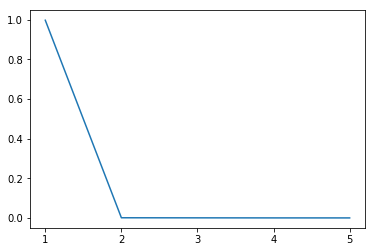

In [24]:
x_ticks = np.arange(len(pca.components_))+1

plt.xticks(x_ticks)
plt.plot(x_ticks, pca.explained_variance_ratio_)
print('total expained variance ratio', np.sum(pca.explained_variance_ratio_))

Below I'm running a NB classifier on the PCA results to see how the model scores. 


In [25]:
# X_features comes from the pca cells above 
X_PCA_train, X_PCA_test, y_train, y_test = train_test_split(X_features, y, test_size=0.20)

model = GaussianNB()
model.fit(X_PCA_train, y_train)

# evaluate the model by measuring its accuracy on the test set 
score = model.score(X_PCA_test, y_test)
print("PCA NB Model Score: ", score)


# make predictions with model
predictions = model.predict(X_PCA_test)

# compute and view confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test, predictions.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, predictions)
print("PCA NB Model Accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test, predictions, average='micro')
print("PCA NB Model Precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test, predictions.astype('i4'), average='micro')
print("PCA NB f1 score: ", f1)

PCA NB Model Score:  0.778333333333
[[2260   23]
 [ 642   75]]
PCA NB Model Accuracy:  0.778333333333
PCA NB Model Precision:  0.778333333333
PCA NB f1 score:  0.778333333333


Now I'll attempt to run the factor analysis and model the data 


In [26]:

# transform features 
fa = FactorAnalysis(n_components=5)
X_FA_features = fa.fit_transform(X)
print('Features shape', X_FA_features.shape)

# split transformed features into training and testing sets 
X_FA_train, X_FA_test, y_train, y_test = train_test_split(X_FA_features, y, test_size=0.20)

# get NB model and fit it to FA tranformed training data 
model = GaussianNB()
model.fit(X_FA_train, y_train)

# evaluate the model by measuring its accuracy on the test set 
score = model.score(X_FA_test, y_test)
print("Factor Analysis NB Model Score: ", score)

# make predictions with model
predictions = model.predict(X_FA_test)

# compute and view confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test, predictions.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, predictions)
print("FA NB Model Accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test, predictions, average='micro')
print("FA NB Model Precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test, predictions.astype('i4'), average='micro')
print("FA NB f1 score: ", f1)

Features shape (14999, 5)
Factor Analysis NB Model Score:  0.762666666667
[[2103  183]
 [ 529  185]]
FA NB Model Accuracy:  0.762666666667
FA NB Model Precision:  0.762666666667
FA NB f1 score:  0.762666666667


### Final Thoughts